base de données exportée du portail data.gouv.fr.

Plus précisément, il s’agit du catalogue des services de données (APIs et flux) publiés sur la plateforme.
Autrement dit, cette base regroupe toutes les API référencées sur data.gouv.fr, avec leurs métadonnées techniques et descriptives.

Objectif :
Analyser la qualité et la complétude des API référencées sur data.gouv.fr.

Lecture du CSV

In [13]:
import pandas as pd
df = pd.read_csv('export-dataservice-20251110-060437.csv', sep=';', quotechar='"')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           444 non-null    object 
 1   title                        444 non-null    object 
 2   slug                         444 non-null    object 
 3   acronym                      20 non-null     object 
 4   url                          444 non-null    object 
 5   description                  345 non-null    object 
 6   base_api_url                 400 non-null    object 
 7   machine_documentation_url    336 non-null    object 
 8   technical_documentation_url  160 non-null    object 
 9   business_documentation_url   203 non-null    object 
 10  authorization_request_url    117 non-null    object 
 11  availability                 86 non-null     float64
 12  rate_limiting                118 non-null    object 
 13  access_type         

Analyse exploratoire :

In [14]:
df.describe(include='all')
df.isna().sum().sort_values(ascending=False)

,0
owner_id,438
owner,438
license,429
acronym,424
availability,358
authorization_request_url,327
rate_limiting,326
technical_documentation_url,284
datasets,254
business_documentation_url,241


2.Mesure des dimensions de Data Quality.


---



In [15]:
completude = 1 - df.isna().sum() / len(df)
completude.sort_values(ascending=False)

,0
id,1.000000
title,1.000000
slug,1.000000
url,1.000000
metadata_modified_at,1.000000
metric.views,1.000000
archived,1.000000
metric.discussions,1.000000
metric.followers,1.000000
metric.discussions_open,1.000000


 3.2. Cohérence

In [16]:
df['availability'].between(0, 100).mean()
df['access_type'].isin(['open', 'open_with_account', 'restricted']).mean()

np.float64(0.8738738738738738)

3.3. Unicité

In [17]:
unicite = 1 - df.duplicated(subset='url').mean()

3.4. Exactitude

In [18]:
import requests
df['url_valid'] = df['url'].apply(lambda x: requests.head(x).status_code == 200)
exactitude = df['url_valid'].mean()

3.5. Actualité (Timeliness)

In [33]:
import pandas as pd

# Lecture du CSV
df = pd.read_csv('export-dataservice-20251110-060437.csv', sep=';', quotechar='"')

# Conversion en datetime
df['metadata_modified_at'] = pd.to_datetime(df['metadata_modified_at'], errors='coerce')

# Calcul du délai en jours depuis la dernière modification
delai_jours = (pd.Timestamp.now() - df['metadata_modified_at']).dt.days

# Délai moyen
delai_moyen = delai_jours.mean()
print(f"📅 Délai moyen depuis la dernière modification : {delai_moyen:.2f} jours")

# Optionnel : convertir en score de timeliness 0-100 (plus c’est récent, plus le score est élevé)
# Exemple simple : si delai_moyen = 0 jours → 100%, si très ancien → score diminue
score_actualite = max(0, 100 - delai_moyen / 30)  # 30 jours = perte de 1 point
print(f"⏱ Score Actualité (0-100) : {score_actualite:.2f}")


📅 Délai moyen depuis la dernière modification : 152.06 jours
⏱ Score Actualité (0-100) : 94.93


✅ Données chargées : (444, 30) lignes x colonnes
                         id                   title                    slug  \
0  6661e09c7230a8fc3b1ec229              API Melodi              api-melodi   
1  6661e3b3ac0706063080aa40       API Données Radar       api-donnees-radar   
2  6661e4099e5c08ae03ef7904  API Bulletin Vigilance  api-bulletin-vigilance   

  acronym                                                url  \
0     NaN  https://www.data.gouv.fr/dataservices/api-melodi/   
1     NaN  https://www.data.gouv.fr/dataservices/api-donn...   
2     NaN  https://www.data.gouv.fr/dataservices/api-bull...   

                                         description  \
0  L'API Melodi donne accès aux données ouvertes ...   
1  Obtenir les données publiques Radar pour la Fr...   
2  Flux de la Vigilance de Météo-France qui indiq...   

                                        base_api_url  \
0                       https://api.insee.fr/melodi/   
1  https://portail-api.meteofrance.fr/we

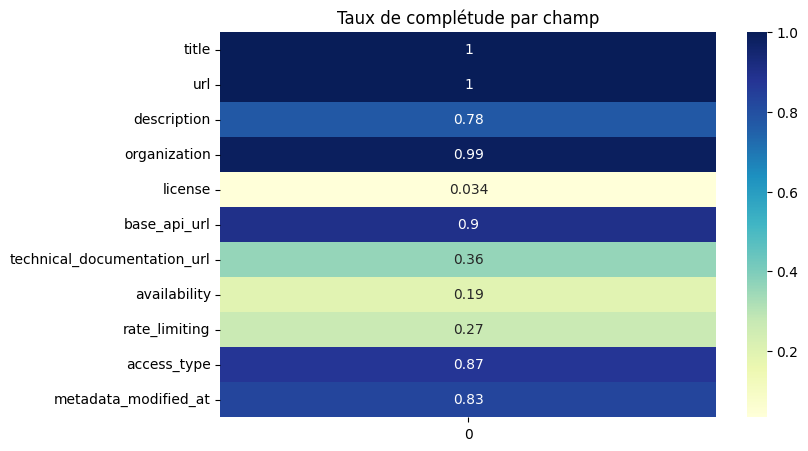

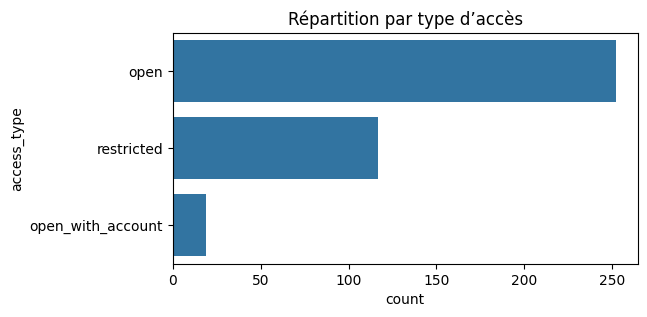

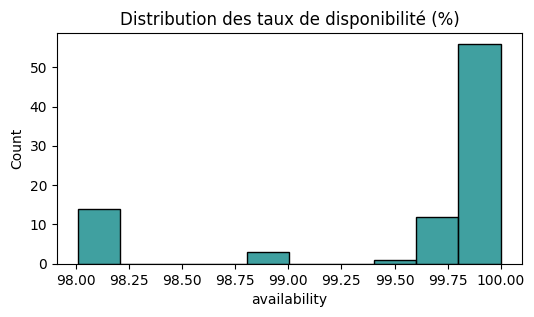


📁 Rapport exporté : rapport_qualite_data_services.csv


In [27]:
# ======================================================================
# ÉVALUATION DE LA QUALITÉ DES DONNÉES - catalogue des APIs data.gouv.fr
# ======================================================================

import pandas as pd
import numpy as np
import requests
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------------------------------------------
# 1️⃣ Chargement des données
# ----------------------------------------------------------------------

file = "export-dataservice-20251110-060437.csv"
df = pd.read_csv(file, sep=';', quotechar='"')

print("✅ Données chargées :", df.shape, "lignes x colonnes")
print(df.head(3))

# ----------------------------------------------------------------------
# 2️⃣ Nettoyage / préparation
# ----------------------------------------------------------------------

# Conversion des dates
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df['metadata_modified_at'] = pd.to_datetime(df['metadata_modified_at'], errors='coerce')

# Conversion numérique du champ 'availability' (peut contenir du texte)
df['availability'] = pd.to_numeric(df['availability'], errors='coerce')

# Liste des colonnes utiles pour l’analyse
cols_utiles = [
    'title', 'url', 'description', 'organization', 'license',
    'base_api_url', 'technical_documentation_url', 'availability',
    'rate_limiting', 'access_type', 'metadata_modified_at'
]
data = df[cols_utiles].copy()

# ----------------------------------------------------------------------
# 3️⃣ Calcul des dimensions de qualité
# ----------------------------------------------------------------------

qualite = {}

# 💠 3.1 Complétude
qualite['completude'] = 1 - data.isna().sum() / len(data)

# 💠 3.2 Cohérence
cond_availability = data['availability'].between(0, 100)
cond_access_type = data['access_type'].isin(['open', 'open_with_account', 'restricted', 'open_data'])

qualite['coherence'] = {
    'availability': cond_availability.mean(),
    'access_type': cond_access_type.mean(),
}

# 💠 3.3 Unicité
qualite['unicite'] = 1 - data.duplicated(subset='url').mean()

# 💠 3.4 Exactitude — test partiel sur 20 URLs
urls_testees = data['url'].dropna().sample(min(20, len(data)))
valid_urls = []
for u in urls_testees:
    try:
        r = requests.head(u, timeout=5)
        valid = r.status_code < 400
    except:
        valid = False
    valid_urls.append(valid)
qualite['exactitude'] = np.mean(valid_urls)

# 💠 3.5 Actualité (timeliness)
delai_moyen = (data['metadata_modified_at'].max() - data['metadata_modified_at']).mean()
qualite['actualite_delai_moyen_jours'] = delai_moyen.days
qualite['actualite_score'] = np.mean(data['metadata_modified_at'] > datetime(2024, 1, 1))

# 💠 3.6 Consistance inter-champs
# Exemple de règle logique : si open -> pas d’URL d’autorisation
if 'authorization_request_url' in df.columns:
    cond_consistency = df.apply(
        lambda r: False if (r['access_type']=='open' and pd.notna(r['authorization_request_url'])) else True,
        axis=1
    )
    qualite['consistance'] = cond_consistency.mean()
else:
    qualite['consistance'] = np.nan

# ----------------------------------------------------------------------
# 4️⃣ Résumé global
# ----------------------------------------------------------------------

print("\n=== 🔍 RAPPORT QUALITÉ DES DONNÉES ===\n")
print("📊 Complétude moyenne :", round(qualite['completude'].mean(), 3))
print("✅ Cohérence - availability :", round(qualite['coherence']['availability'], 3))
print("✅ Cohérence - access_type :", round(qualite['coherence']['access_type'], 3))
print("✅ Unicité :", round(qualite['unicite'], 3))
print("✅ Exactitude (URLs valides sur échantillon) :", round(qualite['exactitude'], 3))
print("⌛ Actualité moyenne :", qualite['actualite_delai_moyen_jours'], "jours")
print("✅ Données récentes (> 2024) :", round(qualite['actualite_score'], 3))
print("✅ Consistance inter-colonnes :", round(qualite['consistance'], 3))

# ----------------------------------------------------------------------
# 5️⃣ Visualisations (optionnel)
# ----------------------------------------------------------------------

plt.figure(figsize=(8,5))
sns.heatmap(pd.DataFrame(qualite['completude']), annot=True, cmap='YlGnBu')
plt.title("Taux de complétude par champ")
plt.show()

plt.figure(figsize=(6,3))
sns.countplot(y=data['access_type'], order=data['access_type'].value_counts().index)
plt.title("Répartition par type d’accès")
plt.show()

plt.figure(figsize=(6,3))
sns.histplot(data['availability'].dropna(), bins=10, color="teal")
plt.title("Distribution des taux de disponibilité (%)")
plt.show()

# ----------------------------------------------------------------------
# 6️⃣ Export du rapport
# ----------------------------------------------------------------------

rapport = pd.DataFrame({
    'dimension': list(qualite.keys()),
    'valeurs': [str(v) for v in qualite.values()]
})
rapport.to_csv("rapport_qualite_data_services.csv", index=False)
print("\n📁 Rapport exporté : rapport_qualite_data_services.csv")

In [30]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime

# -----------------------------
# 1️⃣ Chargement du CSV
# -----------------------------
df = pd.read_csv('export-dataservice-20251110-060437.csv', sep=';', quotechar='"')

# -----------------------------
# 2️⃣ Préparation / Nettoyage
# -----------------------------
# Conversion des dates
if 'metadata_modified_at' in df.columns:
    df['metadata_modified_at'] = pd.to_datetime(df['metadata_modified_at'], errors='coerce')

# Suppression de colonnes inutiles
colonnes_inutiles = ['id', 'slug', 'owner_id']
df.drop(columns=[c for c in colonnes_inutiles if c in df.columns], inplace=True)

# -----------------------------
# 3️⃣ Calcul des métriques Data Quality
# -----------------------------
metrics = {}

# 3.1 Complétude
metrics['Complétude (%)'] = round((1 - df.isna().sum() / len(df)).mean()*100, 2)

# 3.2 Cohérence
coh_scores = []
if 'availability' in df.columns:
    coh_scores.append(df['availability'].between(0, 100).mean())
if 'access_type' in df.columns:
    coh_scores.append(df['access_type'].isin(['open', 'open_with_account', 'restricted']).mean())
metrics['Cohérence (%)'] = round(np.mean(coh_scores)*100, 2)

# 3.3 Unicité
if 'url' in df.columns:
    metrics['Unicité (%)'] = round((1 - df.duplicated(subset='url').mean())*100, 2)

# 3.4 Exactitude (validation des URLs)
if 'url' in df.columns:
    def url_ok(url):
        try:
            return requests.head(url, timeout=2).status_code == 200
        except:
            return False
    df['url_valid'] = df['url'].apply(url_ok)
    metrics['Exactitude (%)'] = round(df['url_valid'].mean()*100, 2)

# 3.5 Actualité (timeliness)
if 'metadata_modified_at' in df.columns:
    days_since_update = (datetime.now() - df['metadata_modified_at']).dt.days
    metrics['Actualité (%)'] = round(max(0, 100 - days_since_update.mean()/30), 2)  # moins le délai, meilleur

# 3.6 Consistance inter-colonnes
# Exemple simple : access_type=open -> authorization_request_url vide
if 'access_type' in df.columns and 'authorization_request_url' in df.columns:
    mask = df['access_type'] == 'open'
    if mask.any():
        consistency = (df.loc[mask, 'authorization_request_url'].isna() | (df.loc[mask, 'authorization_request_url']=='')).mean()
        metrics['Consistance (%)'] = round(consistency*100, 2)

# -----------------------------
# 4️⃣ Affichage
# -----------------------------
print("📊 Data Quality Metrics :")
for k, v in metrics.items():
    print(f"{k}: {v} %")

# -----------------------------
# 5️⃣ Export du rapport
# -----------------------------
rapport = pd.DataFrame({'Dimension': list(metrics.keys()), 'Score (%)': list(metrics.values())})
rapport.to_csv("rapport_qualite_data_services.csv", index=False)
print("\n📁 Rapport exporté : rapport_qualite_data_services.csv")


📊 Data Quality Metrics :
Complétude (%): 69.75 %
Cohérence (%): 53.38 %
Unicité (%): 100.0 %
Exactitude (%): 100.0 %
Actualité (%): 94.93 %
Consistance (%): 96.03 %

📁 Rapport exporté : rapport_qualite_data_services.csv


📊 Data Quality Metrics :
Complétude (%): 69.75 %
Cohérence (%): 53.38 %
Unicité (%): 100.0 %
Exactitude (%): 100.0 %
Actualité (%): 94.93 %
Consistance (%): 96.03 %


/tmp/ipython-input-1944310086.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='access_type', order=df['access_type'].value_counts().index, palette="Set2")


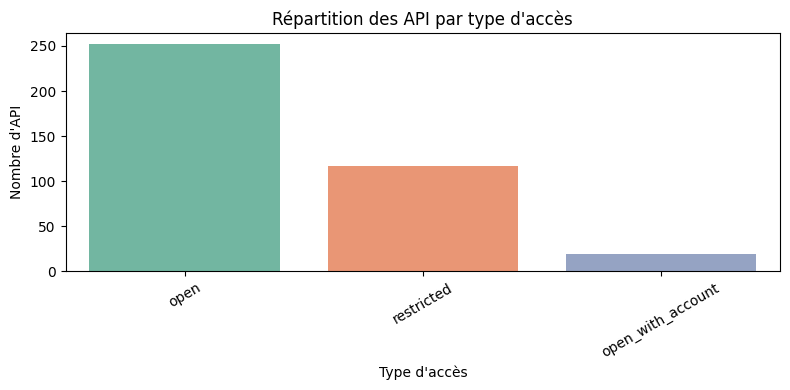

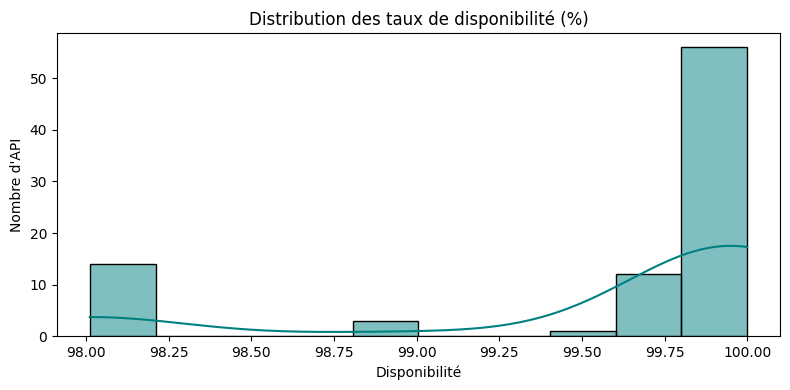

/tmp/ipython-input-1944310086.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=org_avail, x='organization', y='availability', palette="viridis")
/tmp/ipython-input-1944310086.py:108: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


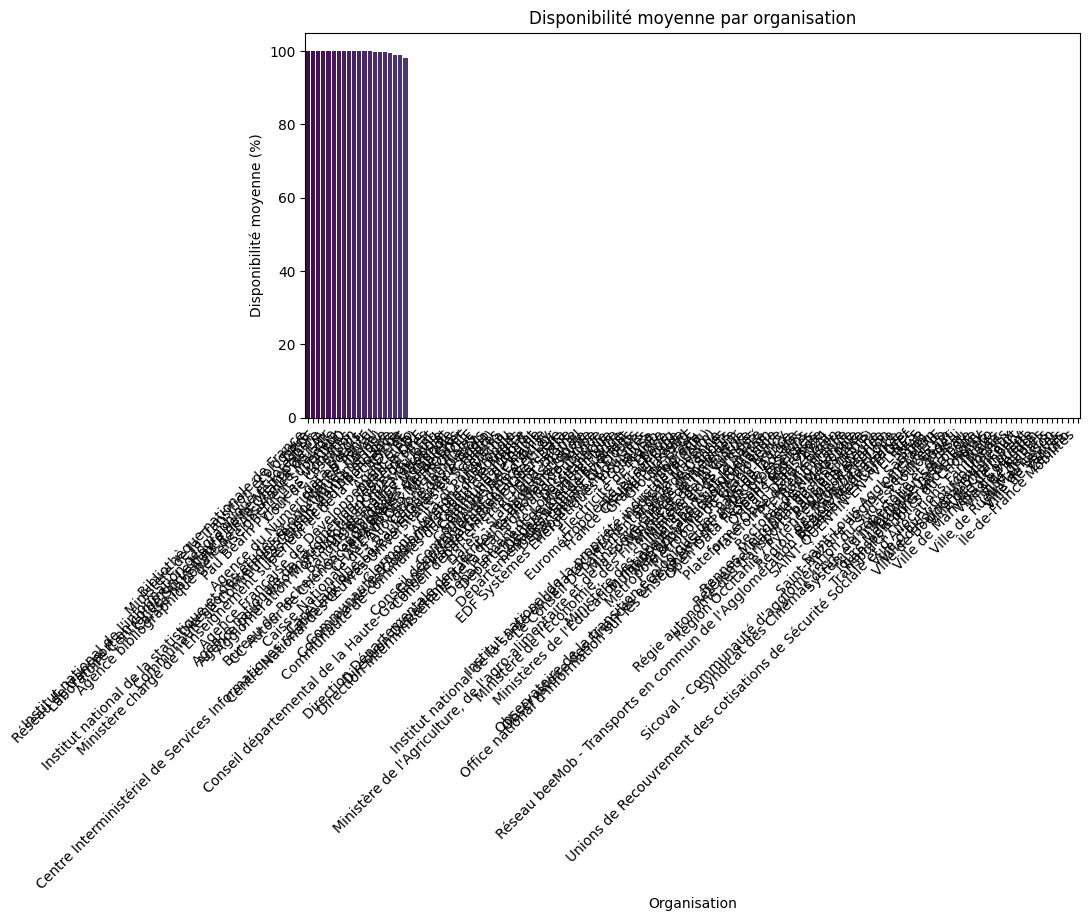

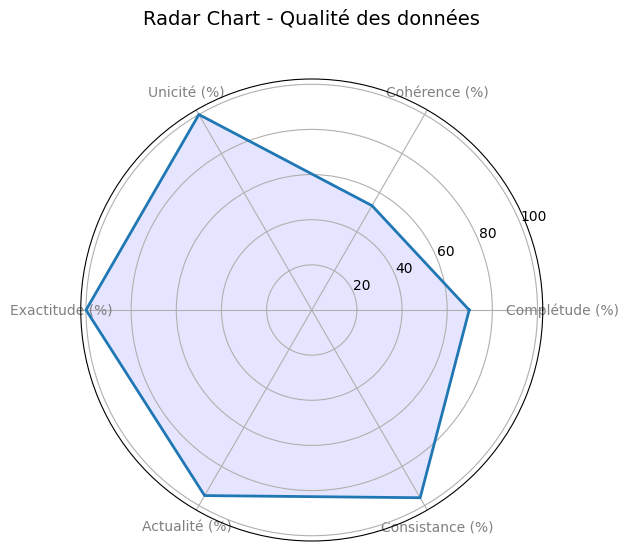


📁 Rapport exporté : rapport_qualite_data_services.csv


In [34]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from math import pi

# -----------------------------
# 1️⃣ Chargement du CSV
# -----------------------------
df = pd.read_csv('export-dataservice-20251110-060437.csv', sep=';', quotechar='"')

# -----------------------------
# 2️⃣ Préparation / Nettoyage
# -----------------------------
# Conversion des colonnes nécessaires
if 'metadata_modified_at' in df.columns:
    df['metadata_modified_at'] = pd.to_datetime(df['metadata_modified_at'], errors='coerce')

if 'availability' in df.columns:
    df['availability'] = pd.to_numeric(df['availability'], errors='coerce')

# Suppression colonnes inutiles
colonnes_inutiles = ['id', 'slug', 'owner_id']
df.drop(columns=[c for c in colonnes_inutiles if c in df.columns], inplace=True)

# -----------------------------
# 3️⃣ Calcul des métriques Data Quality
# -----------------------------
metrics = {}

# 3.1 Complétude
metrics['Complétude (%)'] = round((1 - df.isna().sum() / len(df)).mean()*100, 2)

# 3.2 Cohérence
coh_scores = []
if 'availability' in df.columns:
    coh_scores.append(df['availability'].between(0, 100).mean())
if 'access_type' in df.columns:
    coh_scores.append(df['access_type'].isin(['open', 'open_with_account', 'restricted']).mean())
metrics['Cohérence (%)'] = round(np.mean(coh_scores)*100, 2)

# 3.3 Unicité
if 'url' in df.columns:
    metrics['Unicité (%)'] = round((1 - df.duplicated(subset='url').mean())*100, 2)

# 3.4 Exactitude (validation des URLs)
if 'url' in df.columns:
    def url_ok(url):
        try:
            return requests.head(url, timeout=2).status_code == 200
        except:
            return False
    df['url_valid'] = df['url'].apply(url_ok)
    metrics['Exactitude (%)'] = round(df['url_valid'].mean()*100, 2)

# 3.5 Actualité (Timeliness)
if 'metadata_modified_at' in df.columns:
    delai_jours = (datetime.now() - df['metadata_modified_at']).dt.days
    delai_moyen = delai_jours.mean()
    metrics['Actualité (%)'] = round(max(0, 100 - delai_moyen / 30), 2)  # score simplifié

# 3.6 Consistance inter-colonnes
if 'access_type' in df.columns and 'authorization_request_url' in df.columns:
    mask = df['access_type'] == 'open'
    if mask.any():
        consistency = (df.loc[mask, 'authorization_request_url'].isna() | (df.loc[mask, 'authorization_request_url']=='')).mean()
        metrics['Consistance (%)'] = round(consistency*100, 2)

# -----------------------------
# 4️⃣ Affichage des résultats
# -----------------------------
print("📊 Data Quality Metrics :")
for k, v in metrics.items():
    print(f"{k}: {v} %")

# -----------------------------
# 5️⃣ Visualisation avec seaborn
# -----------------------------
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='access_type', order=df['access_type'].value_counts().index, palette="Set2")
plt.title("Répartition des API par type d'accès")
plt.xlabel("Type d'accès")
plt.ylabel("Nombre d'API")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

if 'availability' in df.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(df['availability'].dropna(), bins=10, color="teal", kde=True)
    plt.title("Distribution des taux de disponibilité (%)")
    plt.xlabel("Disponibilité")
    plt.ylabel("Nombre d'API")
    plt.tight_layout()
    plt.show()

# Disponibilité moyenne par organisation
if 'organization' in df.columns and 'availability' in df.columns:
    plt.figure(figsize=(10,5))
    org_avail = df.groupby('organization')['availability'].mean().sort_values(ascending=False).reset_index()
    sns.barplot(data=org_avail, x='organization', y='availability', palette="viridis")
    plt.title("Disponibilité moyenne par organisation")
    plt.xlabel("Organisation")
    plt.ylabel("Disponibilité moyenne (%)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# -----------------------------
# 6️⃣ Radar chart pour Data Quality
# -----------------------------
categories = list(metrics.keys())
values = list(metrics.values())
values += values[:1]  # fermer le radar

angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]

plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], categories, color='grey', size=10)
ax.plot(angles, values, linewidth=2, linestyle='solid', label='Data Quality Score')
ax.fill(angles, values, 'b', alpha=0.1)
plt.title("Radar Chart - Qualité des données", size=14, y=1.1)
plt.show()

# -----------------------------
# 7️⃣ Export rapport CSV
# -----------------------------
rapport = pd.DataFrame({'Dimension': list(metrics.keys()), 'Score (%)': list(metrics.values())})
rapport.to_csv("rapport_qualite_data_services.csv", index=False)
print("\n📁 Rapport exporté : rapport_qualite_data_services.csv")
